# House Price Prediction with Linear Regression

![](https://i.imgur.com/3sw1fY9.jpg)

## Download the Data

The dataset is available as a ZIP file at the following url:

Note: Remove semi-colon to show output

In [1]:
dataset_url = 'https://github.com/JovianML/opendatasets/raw/master/data/house-prices-advanced-regression-techniques.zip'

In [2]:
from urllib.request import urlretrieve

In [3]:
# download zip file using urlretrieve 
urlretrieve(dataset_url, 'house-prices.zip')

('house-prices.zip', <http.client.HTTPMessage at 0x7fd8e01137f0>)

The file `housing-prices.zip` has been downloaded. Let's unzip it using the [`zipfile`](https://docs.python.org/3/library/zipfile.html) module.

In [4]:
from zipfile import ZipFile

In [5]:
with ZipFile('house-prices.zip') as f:
    f.extractall(path='house-prices')

The dataset is extracted to the folder `house-prices`. 

In [6]:
import os

In [7]:
data_dir = 'house-prices'

In [8]:
# list the contents of ```house-prices```
os.listdir(data_dir);

## Exploratory Data Analysis

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [10]:
train_csv_path = data_dir + '/train.csv'
train_csv_path

'house-prices/train.csv'

> **QUESTION 1**: Load the data from the file `train.csv` into a Pandas data frame.

In [11]:
prices_df = pd.read_csv(train_csv_path)

In [12]:
prices_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
prices_df.info()

> **QUESTION 2**: How many rows and columns does the dataset contain? 

In [13]:
n_rows = prices_df.shape[0]

In [14]:
n_cols = prices_df.shape[1]

In [15]:
print('The dataset contains {} rows and {} columns.'.format(n_rows, n_cols))

The dataset contains 1460 rows and 81 columns.


> **(OPTIONAL) QUESTION**: Before training the model, you may want to explore and visualize data from the various columns within the dataset, and study their relationship with the price of the house (using scatter plot and correlations). Create some graphs and summarize your insights using the empty cells below.

### What is the distribution of house prices?

In [16]:
prices_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

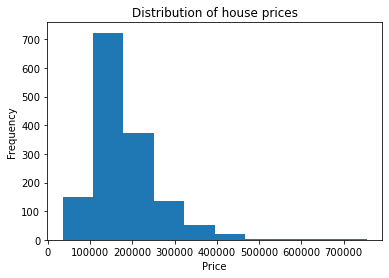

In [17]:
plt.hist(data=prices_df, x='SalePrice');
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of house prices');

The minimum house price in our data is around ```$18,000``` and on average a house cost ```$163,000```. Also, the data is skewed to the right due to some extremely high house prices.

### What's is the correlation between other columns and ```SalePrice```?

### Lot Size

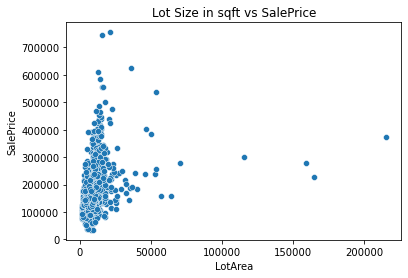

In [18]:
sns.scatterplot(data=prices_df, x='LotArea', y='SalePrice')
plt.title('Lot Size in sqft vs SalePrice');

The lot size seems to cluster around a point with few outliers to the right. I don't see a very strong correlation from the above plot

### Does the size of the basement contribute to an increase in house price?

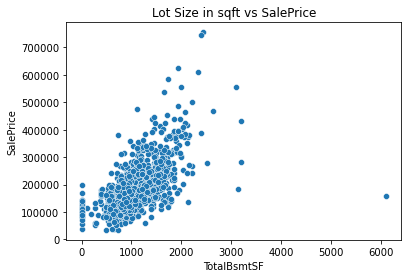

In [19]:
sns.scatterplot(data=prices_df, x='TotalBsmtSF', y ='SalePrice')
plt.title('Lot Size in sqft vs SalePrice');

There is quite a fairly strong correlation between the size of the basement of a house and its price.

### Overall Condition of each house 

To aid redability, the corresponding values of each integer in ```OverallCond``` is saved in a dictionary and replaced inplace. Description of the dataset can be found [here]()

In [20]:
mapping_condition = {10: 'Very Excellent', 9: 'Excellent', 8: 'Very Good', 7: 'Good',
           6: 'Above Average', 5: 'Average', 4: 'Below Average', 3: 'Fair',
           2: 'Poor', 1: 'Very Poor'}

prices_df['OverallCond'] = prices_df['OverallCond'].map(mapping_condition)

In [21]:
data = prices_df.groupby('OverallCond').mean()['SalePrice']
data;

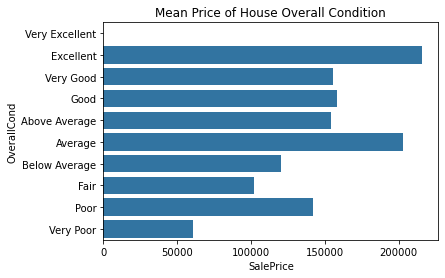

In [22]:
base_color = sns.color_palette()[0]
order = list(mapping_condition.values())
sns.barplot(data, data.index, color=base_color, order=order)
plt.title('Mean Price of House Overall Condition');

### Price and Foundation Type

In [23]:
mapping_foundation = {'BrkTil': 'Brick & Tile', 'CBlock': 'Cinder Block', 'PConc': 'Poured Contrete',
                       'Slab': 'Slab', 'Stone': 'Stone', 'Wood': 'Wood'}

prices_df['Foundation'] = prices_df['Foundation'].map(mapping_foundation)

In [24]:
data_foundation = prices_df.groupby('Foundation').mean()['SalePrice'].sort_values(ascending=False)
data_foundation

Foundation
Poured Contrete    225230.442040
Wood               185666.666667
Stone              165959.166667
Cinder Block       149805.714511
Brick & Tile       132291.075342
Slab               107365.625000
Name: SalePrice, dtype: float64

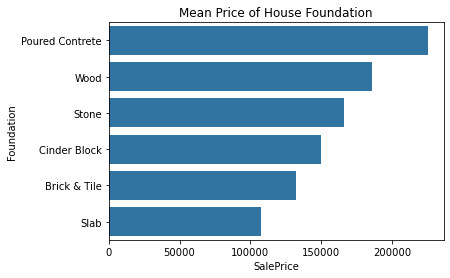

In [25]:
sns.barplot(data_foundation, data_foundation.index, color=base_color)
plt.title('Mean Price of House Foundation');

Houses with poured concrete foundation have the highest mean sale price 

## Prepare the Dataset for Training

Before we can train the model, we need to prepare the dataset. Here are the steps we'll follow:

1. Identify the input and target column(s) for training the model.
2. Identify numeric and categorical input columns.
3. [Impute](https://scikit-learn.org/stable/modules/impute.html) (fill) missing values in numeric columns
4. [Scale](https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) values in numeric columns to a $(0,1)$ range.
5. [Encode](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) categorical data into one-hot vectors.
6. Split the dataset into training and validation sets.


### Identify Inputs and Targets

While the dataset contains 81 columns, not all of them are useful for modeling. Note the following:

- The first column `Id` is a unique ID for each house and isn't useful for training the model.
- The last column `SalePrice` contains the value we need to predict i.e. it's the target column.
- Data from all the other columns (except the first and the last column) can be used as inputs to the model.
 

> **QUESTION 3**: Create a list `input_cols` of column names containing data that can be used as input to train the model, and identify the target column as the variable `target_col`.

In [26]:
prices_df.columns[1:-1];

In [27]:
prices_df.columns[-1]

'SalePrice'

In [28]:
# Identify the input columns (a list of column names)
input_cols = prices_df.columns[1:-1]

In [29]:
# Identify the name of the target column (a single string, not a list)
target_col = prices_df.columns[-1]

In [30]:
input_cols;

In [31]:
print(target_col)

SalePrice


Now that we've identified the input and target columns, we can separate input & target data.

In [32]:
inputs_df = prices_df[input_cols].copy()

In [33]:
targets = prices_df[target_col]

In [34]:
inputs_df;

In [35]:
targets;

### Identify Numeric and Categorical Data

The next step in data preparation is to identify numeric and categorical columns. We can do this by looking at the data type of each column.

> **QUESTION 4**: Crate two lists `numeric_cols` and `categorical_cols` containing names of numeric and categorical input columns within the dataframe respectively. Numeric columns have data types `int64` and `float64`, whereas categorical columns have the data type `object`.
>
> *Hint*: See this [StackOverflow question](https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas). 

# import numpy as np

In [36]:
numeric_cols = inputs_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [37]:
categorical_cols = inputs_df.select_dtypes(include=['object']).columns.tolist()

In [38]:
numeric_cols;

In [39]:
categorical_cols;

In [ ]:
prices_df[categorical_cols].info()

### Impute Numerical Data

Some of the numeric columns in our dataset contain missing values (`nan`).

In [41]:
missing_counts = inputs_df[numeric_cols].isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0]

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

Machine learning models can't work with missing data. The process of filling missing values is called [imputation](https://scikit-learn.org/stable/modules/impute.html).

<img src="https://i.imgur.com/W7cfyOp.png" width="480">

There are several techniques for imputation, but we'll use the most basic one: replacing missing values with the average value in the column using the `SimpleImputer` class from `sklearn.impute`.


In [42]:
from sklearn.impute import SimpleImputer

> **QUESTION 5**: Impute (fill) missing values in the numeric columns of `inputs_df` using a `SimpleImputer`. 
>
> *Hint*: See [this notebook](https://jovian.ai/aakashns/python-sklearn-logistic-regression/v/66#C88).

In [43]:
# 1. Create the imputer
imputer = SimpleImputer(strategy='mean')

In [44]:
# 2. Fit the imputer to the numeric colums
imputer.fit(prices_df[numeric_cols])

SimpleImputer()

In [45]:
# 3. Transform and replace the numeric columns
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])

After imputation, none of the numeric columns should contain any missing values.

In [46]:
missing_counts = inputs_df[numeric_cols].isna().sum().sort_values(ascending=False)
missing_counts[missing_counts > 0] # should be an empty list

Series([], dtype: int64)

### Scale Numerical Values

The numeric columns in our dataset have varying ranges. 

In [47]:
inputs_df[numeric_cols].describe().loc[['min', 'max']]

,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
min,20.0,21.0,1300.0,1.0,1872.0,1950.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0
max,190.0,313.0,215245.0,10.0,2010.0,2010.0,1600.0,5644.0,1474.0,2336.0,...,1418.0,857.0,547.0,552.0,508.0,480.0,738.0,15500.0,12.0,2010.0


A good practice is to [scale numeric features](https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) to a small range of values e.g. $(0,1)$. Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.


> **QUESTION 6**: Scale numeric values to the $(0, 1)$ range using `MinMaxScaler` from `sklearn.preprocessing`.
>
> *Hint*: See [this notebook](https://jovian.ai/aakashns/python-sklearn-logistic-regression/v/66#C104).

In [48]:
from sklearn.preprocessing import MinMaxScaler

In [49]:
# Create the scaler
scaler = MinMaxScaler()

In [50]:
# Fit the scaler to the numeric columns
scaler.fit(prices_df[numeric_cols])

MinMaxScaler()

In [51]:
# Transform and replace the numeric columns
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

After scaling, the ranges of all numeric columns should be $(0, 1)$.

In [52]:
inputs_df[numeric_cols].describe().loc[['min', 'max']]

,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Encode Categorical Columns

Our dataset contains several categorical columns, each with a different number of categories.

In [53]:
inputs_df[categorical_cols].nunique().sort_values(ascending=False);



Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column.

> **QUESTION 7**: Encode categorical columns in the dataset as one-hot vectors using `OneHotEncoder` from `sklearn.preprocessing`. Add a new binary (0/1) column for each category
> 
> *Hint*: See [this notebook](https://jovian.ai/aakashns/python-sklearn-logistic-regression/v/66#C122).

In [54]:
from sklearn.preprocessing import OneHotEncoder

In [55]:
# 1. Create the encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [56]:
# 2. Fit the encoder to the categorical colums
encoder.fit(prices_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [57]:
# 3. Generate column names for each category
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
len(encoded_cols)

277

In [58]:
# 4. Transform and add new one-hot category columns
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

The new one-hot category columns should now be added to `inputs_df`.

### Training and Validation Set

Finally, let's split the dataset into a training and validation set. We'll use a randomly select 25% subset of the data for validation. Also, we'll use just the numeric and encoded columns, since the inputs to our model must be numbers. 

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs_df[numeric_cols + encoded_cols], 
                                                                        targets, 
                                                                        test_size=0.25, 
                                                                        random_state=42)

In [61]:
train_inputs

,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1023,0.588235,0.075342,0.008797,0.666667,0.963768,0.933333,0.008750,0.002835,0.000000,0.569349,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
810,0.000000,0.195205,0.041319,0.555556,0.739130,0.816667,0.061875,0.117470,0.255767,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1384,0.176471,0.133562,0.036271,0.555556,0.485507,0.000000,0.000000,0.036145,0.000000,0.152397,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
626,0.000000,0.167979,0.051611,0.444444,0.637681,0.466667,0.000000,0.000000,0.000000,0.418664,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
813,0.000000,0.184932,0.039496,0.555556,0.623188,0.133333,0.151875,0.107725,0.000000,0.357021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.000000,0.195205,0.037472,0.555556,0.971014,0.933333,0.000000,0.004252,0.000000,0.552226,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1130,0.176471,0.150685,0.030400,0.333333,0.405797,0.000000,0.000000,0.110206,0.000000,0.214041,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1294,0.000000,0.133562,0.032120,0.444444,0.601449,0.666667,0.000000,0.029589,0.000000,0.298373,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
860,0.176471,0.116438,0.029643,0.666667,0.333333,0.800000,0.000000,0.000000,0.000000,0.390411,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [62]:
train_targets

1023    191000
810     181000
1384    105000
626     139900
813     157900
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 1095, dtype: int64

In [64]:
val_inputs;

In [65]:
val_targets;

## Step 3 - Train a Linear Regression Model

We're now ready to train the model. Linear regression is a commonly used technique for solving [regression problems](https://jovian.ai/aakashns/python-sklearn-logistic-regression/v/66#C6). In a linear regression model, the target is modeled as a linear combination (or weighted sum) of input features. The predictions from the model are evaluated using a loss function like the Root Mean Squared Error (RMSE).


Here's a visual summary of how a linear regression model is structured:

<img src="https://i.imgur.com/iTM2s5k.png" width="480">

However, linear regression doesn't generalize very well when we have a large number of input columns with co-linearity i.e. when the values one column are highly correlated with values in other column(s). This is because it tries to fit the training data perfectly. 

Instead, we'll use Ridge Regression, a variant of linear regression that uses a technique called L2 regularization to introduce another loss term that forces the model to generalize better. Learn more about ridge regression here: https://www.youtube.com/watch?v=Q81RR3yKn30

> **QUESTION 8**: Create and train a linear regression model using the `Ridge` class from `sklearn.linear_model`.

In [66]:
from sklearn.linear_model import Ridge

In [67]:
# Create the model
model = Ridge()

In [68]:
# Fit the model using inputs and targets
model.fit(train_inputs, train_targets)

Ridge()

`model.fit` uses the following strategy for training the model (source):

1. We initialize a model with random parameters (weights & biases).
2. We pass some inputs into the model to obtain predictions.
3. We compare the model's predictions with the actual targets using the loss function.
4. We use an optimization technique (like least squares, gradient descent etc.) to reduce the loss by adjusting the weights & biases of the model
5. We repeat steps 1 to 4 till the predictions from the model are good enough.

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

## Step 4 - Make Predictions and Evaluate Your Model

The model is now trained, and we can use it to generate predictions for the training and validation inputs. We can evaluate the model's performance using the RMSE (root mean squared error) loss function.

> **QUESTION 9**: Generate predictions and compute the RMSE loss for the training and validation sets. 
> 
> *Hint*: Use the `mean_squared_error` with the argument `squared=False` to compute RMSE loss.

In [69]:
from sklearn.metrics import mean_squared_error

In [70]:
train_preds = model.predict(train_inputs)

In [71]:
train_preds

array([172586.76008995, 176949.20748914, 104911.63988729, ...,
       123614.97185668, 170450.79328578, 190859.27900072])

In [72]:
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)

In [73]:
print('The RMSE loss for the training set is $ {}.'.format(train_rmse))

The RMSE loss for the training set is $ 21804.60856719364.


In [74]:
val_preds = model.predict(val_inputs)

In [75]:
val_preds;

In [76]:
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)

In [77]:
print('The RMSE loss for the validation set is $ {}.'.format(val_rmse))

The RMSE loss for the validation set is $ 28844.842206653768.


### Feature Importance

Let's look at the weights assigned to different columns, to figure out which columns in the dataset are the most important.

> **QUESTION 10**: Identify the weights (or coefficients) assigned to for different features by the model.
> 
> *Hint:* Read [the docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [78]:
weights = model.coef_

Let's create a dataframe to view the weight assigned to each column.

In [79]:
weights_df = pd.DataFrame({
    'columns': train_inputs.columns,
    'weight': weights
}).sort_values('weight', ascending=False)

In [81]:
weights_df;

Can you tell which columns have the greatest impact on the price of the house?

### Making Predictions

The model can be used to make predictions on new inputs using the following helper function:

In [82]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols].values)
    X_input = input_df[numeric_cols + encoded_cols]
    return model.predict(X_input)[0]

In [83]:
sample_input = { 'MSSubClass': 20, 'MSZoning': 'RL', 'LotFrontage': 77.0, 'LotArea': 9320,
 'Street': 'Pave', 'Alley': None, 'LotShape': 'IR1', 'LandContour': 'Lvl', 'Utilities': 'AllPub',
 'LotConfig': 'Inside', 'LandSlope': 'Gtl', 'Neighborhood': 'NAmes', 'Condition1': 'Norm', 'Condition2': 'Norm',
 'BldgType': '1Fam', 'HouseStyle': '1Story', 'OverallQual': 4, 'OverallCond': 5, 'YearBuilt': 1959,
 'YearRemodAdd': 1959, 'RoofStyle': 'Gable', 'RoofMatl': 'CompShg', 'Exterior1st': 'Plywood',
 'Exterior2nd': 'Plywood', 'MasVnrType': 'None','MasVnrArea': 0.0,'ExterQual': 'TA','ExterCond': 'TA',
 'Foundation': 'CBlock','BsmtQual': 'TA','BsmtCond': 'TA','BsmtExposure': 'No','BsmtFinType1': 'ALQ',
 'BsmtFinSF1': 569,'BsmtFinType2': 'Unf','BsmtFinSF2': 0,'BsmtUnfSF': 381,
 'TotalBsmtSF': 950,'Heating': 'GasA','HeatingQC': 'Fa','CentralAir': 'Y','Electrical': 'SBrkr', '1stFlrSF': 1225,
 '2ndFlrSF': 0, 'LowQualFinSF': 0, 'GrLivArea': 1225, 'BsmtFullBath': 1, 'BsmtHalfBath': 0, 'FullBath': 1,
 'HalfBath': 1, 'BedroomAbvGr': 3, 'KitchenAbvGr': 1,'KitchenQual': 'TA','TotRmsAbvGrd': 6,'Functional': 'Typ',
 'Fireplaces': 0,'FireplaceQu': np.nan,'GarageType': np.nan,'GarageYrBlt': np.nan,'GarageFinish': np.nan,'GarageCars': 0,
 'GarageArea': 0,'GarageQual': np.nan,'GarageCond': np.nan,'PavedDrive': 'Y', 'WoodDeckSF': 352, 'OpenPorchSF': 0,
 'EnclosedPorch': 0,'3SsnPorch': 0, 'ScreenPorch': 0, 'PoolArea': 0, 'PoolQC': np.nan, 'Fence': np.nan, 'MiscFeature': 'Shed',
 'MiscVal': 400, 'MoSold': 1, 'YrSold': 2010, 'SaleType': 'WD', 'SaleCondition': 'Normal'}

In [84]:
predicted_price = predict_input(sample_input)

In [85]:
print('The predicted sale price of the house is ${}'.format(predicted_price))

The predicted sale price of the house is $121308.45605677945


Change the values in `sample_input` above and observe the effects on the predicted price. 

### Saving the model

Let's save the model (along with other useful objects) to disk, so that we use it for making predictions without retraining.

In [86]:
import joblib

In [87]:
house_price_predictor = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [88]:
joblib.dump(house_price_predictor, 'house_price_predictor.joblib')

['house_price_predictor.joblib']

Congratulations on training and evaluating your first machine learning model using `scikit-learn`! Let's save our work before continuing. We'll include the saved model as an output.